In [7]:
import numpy as np
import tensorflow as tf
import tensorflow.lite as tflite
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalsePositives, FalseNegatives
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow_model_optimization.quantization.keras import quantize_model
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm
import keras_tuner as kt

print(f'Tensorflow v{tf.__version__}')

Tensorflow v2.12.0


In [9]:
# todo: change 'arr_0' after regenerating data

train_dataset = np.load('train.npz', allow_pickle=True)['arr_0']
val_dataset = np.load('val.npz', allow_pickle=True)['arr_0']
test_dataset = np.load('test.npz', allow_pickle=True)['arr_0']

In [33]:
QUANTIZATION = True
HYPERTUNING = True

EPOCHS=30
BATCH_SIZE=256

INPUT_SHAPE = train_dataset[0][0].shape

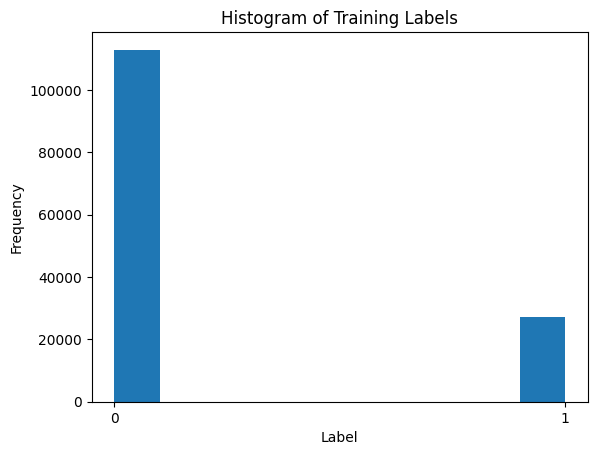

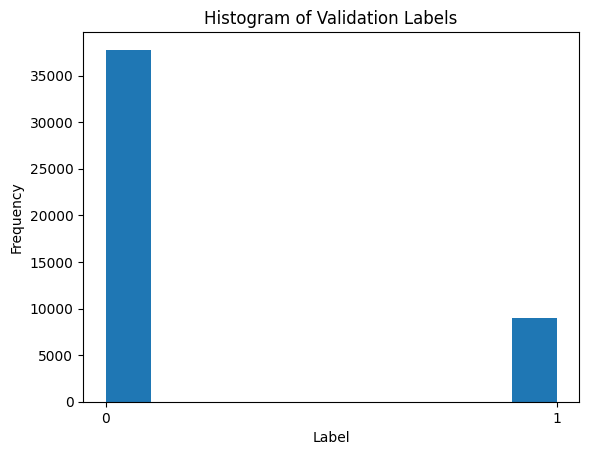

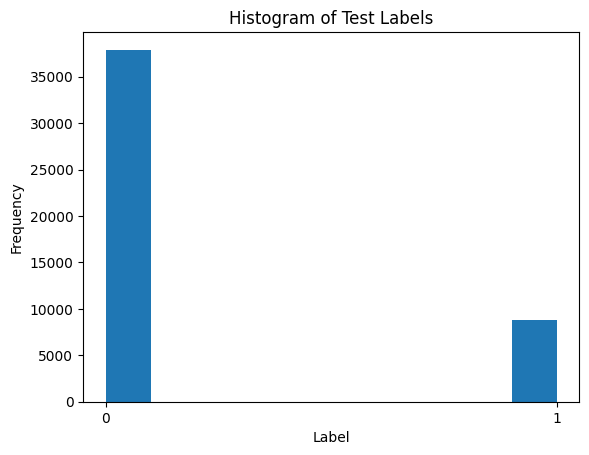

In [10]:
def draw_histogram(Y, name=''):
    plt.hist(Y)
    plt.title(f'Histogram of {name} Labels')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks([0, 1])
    plt.show()

draw_histogram(train_dataset[:, 1], 'Training')
draw_histogram(val_dataset[:, 1], 'Validation')
draw_histogram(test_dataset[:, 1], 'Test')

In [34]:
train_x = np.array([np.array(x, dtype=np.float32) for x in train_dataset[:, 0]])
train_y = np.array([np.array(x, dtype=np.float32) for x in train_dataset[:, 1]])

val_x = np.array([np.array(x, dtype=np.float32) for x in val_dataset[:, 0]])
val_y = np.array([np.array(x, dtype=np.float32) for x in val_dataset[:, 1]])

test_x = np.array([np.array(x, dtype=np.float32) for x in test_dataset[:, 0]])
test_y = np.array([np.array(x, dtype=np.float32) for x in test_dataset[:, 1]])


train_ds = Dataset.from_tensor_slices(
    (train_x, train_y)
).shuffle(train_dataset.shape[0]).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = Dataset.from_tensor_slices(
    (val_x, val_y)
).batch(val_dataset.shape[0] // 10)

In [42]:
def build_model(conv1_filters, conv1_kernel, pooling1, conv2_filters, conv2_kernel, pooling2, dense_units, dropout, learning_rate):
    model = Sequential(
        name='wake_word',
        layers=[
            Conv2D(
                filters=conv1_filters,
                kernel_size=conv1_kernel,
                activation='relu',
                padding='same',
                input_shape=INPUT_SHAPE,
                name='conv2d_1'
            ),
            MaxPooling2D(
                pool_size=pooling1,
                padding='same',
                name='pool2d_1'
            ),
            Dropout(
                rate=dropout,
                name='dropout_1'
            ),
            Conv2D(
                filters=conv2_filters,
                kernel_size=conv2_kernel,
                activation='relu',
                padding='same',
                name='conv2d_2'
            ),
            MaxPooling2D(
                pool_size=pooling2,
                padding='same',
                name='pool2d_2'
            ),
            Dropout(
                rate=dropout,
                name='dropout_2'
            ),
            Flatten(),
            Dense(
                units=dense_units,
                activation='relu',
                name='dense_1'
            ),
            Dropout(
                rate=dropout,
                name='dropout_3'
            ),
            Dense(
                units=1,
                activation='sigmoid',
                name='output'
            )
        ]
    )
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(),
            Precision(),
            Recall(),
            FalsePositives(),
            FalseNegatives()
        ]
    )
    
    return model

def model_builder(hp):
    conv1_filters = hp.Choice('conv1_filters', values=[16, 32, 64])
    conv1_kernel = hp.Choice('conv1_kernel', values=[3, 5, 7])
    pooling1 = hp.Choice('pooling1', values=[2, 3, 4])
    conv2_filters = hp.Choice('conv2_filters', values=[32, 64, 128])
    conv2_kernel = hp.Choice('conv2_kernel', values=[3, 5])
    pooling2 = hp.Choice('pooling2', values=[2, 3, 4])
    dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3])
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    return build_model(
        conv1_filters,
        conv1_kernel,
        pooling1,
        conv2_filters,
        conv2_kernel,
        pooling2,
        dense_units,
        dropout,
        learning_rate
    )

if HYPERTUNING:
    tuner = kt.Hyperband(
        model_builder,
        objective='val_binary_accuracy',
        max_epochs=EPOCHS * 2,
        directory='hp_tuner',
        project_name='wake_word'
#         overwrite=True,
    )
    tuner.search_space_summary()


INFO:tensorflow:Reloading Tuner from hp_tuner/wake_word/tuner0.json


INFO:tensorflow:Reloading Tuner from hp_tuner/wake_word/tuner0.json


Search space summary
Default search space size: 9
conv1_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
conv1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
pooling1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
conv2_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
conv2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pooling2 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [43]:
if HYPERTUNING:
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    tuner.search(test_x, test_y, epochs=EPOCHS, validation_data=(val_x, val_y), callbacks=[stop_early])
#     best_hps = tuner.get_best_hyperparameters(num_trials=1)
#     print(best_hps)
    tuner.results_summary()

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in hp_tuner/wake_word
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 0073 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 3
pooling1: 4
conv2_filters: 128
conv2_kernel: 3
pooling2: 3
dropout: 0.1
dense_units: 32
learning_rate: 0.001
tuner/epochs: 60
tuner/initial_epoch: 20
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.9981586933135986

Trial 0068 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 7
pooling1: 4
conv2_filters: 128
conv2_kernel: 5
pooling2: 4
dropout: 0.1
dense_units: 96
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0057
Score: 0.9981158971786499

Trial 0082 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel: 7
pooling1: 3
conv2_filters: 64
conv2_kernel: 5
pooling2: 3
dropout: 0.1
dense_units: 64
learning_rate: 0.0001
tuner/epochs: 60
tuner/initial_epoch: 20
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0079
Sco

In [53]:
best_models = tuner.get_best_models(num_models=1)

Model: "wake_word"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 99, 43, 64)        640       
                                                                 
 pool2d_1 (MaxPooling2D)     (None, 25, 11, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 25, 11, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 11, 128)       73856     
                                                                 
 pool2d_2 (MaxPooling2D)     (None, 9, 4, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 9, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0 

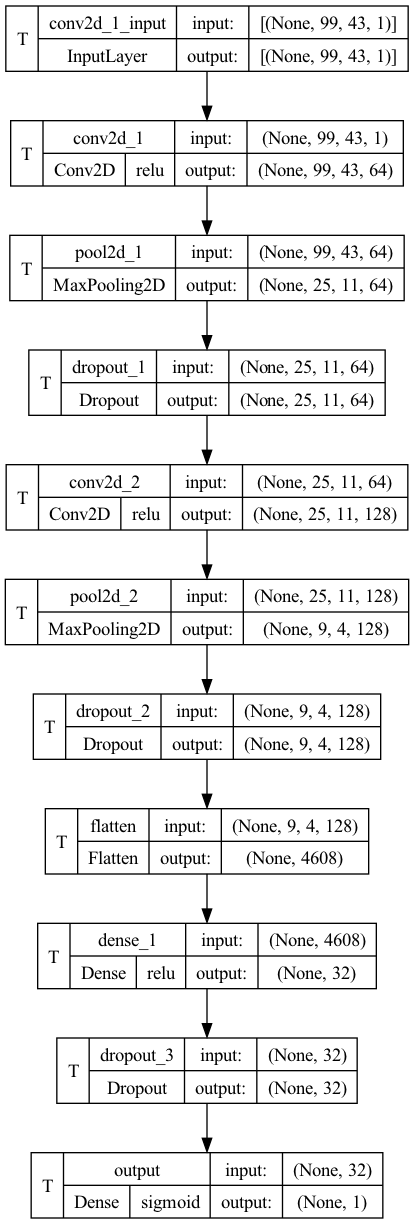

In [44]:
# todo: consider changing padding or test in tuner

model = best_models[0]

# model = Sequential(
#     name='wake_word',
#     layers=[
#         Conv2D(
#             filters=16,
#             kernel_size=5,
#             activation='relu',
#             padding='same',
#             input_shape=INPUT_SHAPE,
#             name='conv2d_1'
#         ),
#         MaxPooling2D(
#             pool_size=[2, 2],
#             padding='same',
#             name='pool2d_1'
#         ),
#         Dropout(
#             rate=0.1,
#             name='dropout_1'
#         ),
#         Conv2D(
#             filters=32,
#             kernel_size=3,
#             activation='relu',
#             padding='same',
#             name='conv2d_2'
#         ),
#         MaxPooling2D(
#             pool_size=[3, 3],
#             padding='same',
#             name='pool2d_2'
#         ),
#         Dropout(
#             rate=0.1,
#             name='dropout_2'
#         ),
#         Flatten(),
#         Dense(
#             units=64,
#             activation='relu',
#             name='dense_1'
#         ),
#         Dropout(
#             rate=0.1,
#             name='dropout_3'
#         ),
#         Dense(
#             units=1,
#             activation='sigmoid',
#             name='output'
#         )
#     ]
# )


# model.compile(
#     optimizer=Adam(),
#     loss=BinaryCrossentropy(),
#     metrics=[
#         BinaryAccuracy(),
#         Precision(),
#         Recall(),
#         FalsePositives(),
#         FalseNegatives()
#     ]
# )

model.summary()

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_activations=True,
    show_trainable=True
)

In [45]:
earlystop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop]
)

Epoch 1/30
548/548 [==============================] - 99s 174ms/step - loss: 0.0094 - binary_accuracy: 0.9970 - precision: 0.9913 - recall: 0.9935 - false_positives: 237.0000 - false_negatives: 178.0000 - val_loss: 0.0040 - val_binary_accuracy: 0.9987 - val_precision: 0.9960 - val_recall: 0.9971 - val_false_positives: 36.0000 - val_false_negatives: 26.0000
Epoch 2/30
548/548 [==============================] - 84s 153ms/step - loss: 0.0057 - binary_accuracy: 0.9982 - precision: 0.9944 - recall: 0.9963 - false_positives: 153.0000 - false_negatives: 100.0000 - val_loss: 0.0035 - val_binary_accuracy: 0.9989 - val_precision: 0.9981 - val_recall: 0.9962 - val_false_positives: 17.0000 - val_false_negatives: 34.0000
Epoch 3/30
548/548 [==============================] - 84s 153ms/step - loss: 0.0047 - binary_accuracy: 0.9985 - precision: 0.9953 - recall: 0.9970 - false_positives: 129.0000 - false_negatives: 81.0000 - val_loss: 0.0033 - val_binary_accuracy: 0.9990 - val_precision: 0.9959 - val_r

In [47]:
model.evaluate(test_x, test_y, batch_size=BATCH_SIZE)

183/183 [==============================] - 10s 50ms/step - loss: 4.3506e-04 - binary_accuracy: 0.9999 - precision: 0.9994 - recall: 0.9999 - false_positives: 5.0000 - false_negatives: 1.0000


[0.000435059453593567,
 0.999871551990509,
 0.9994325637817383,
 0.9998864531517029,
 5.0,
 1.0]

1460/1460 [==============================] - 13s 9ms/step


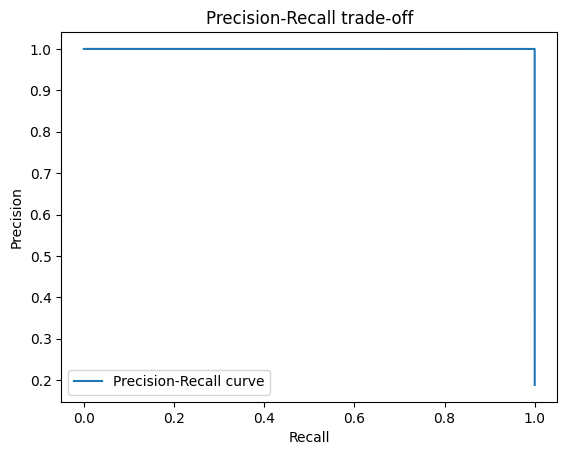

Threshold that maximizes F1 score:  0.7636501


In [48]:
scores = model.predict(test_x)
precision, recall, thresholds = precision_recall_curve(test_y, scores)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall trade-off')
plt.legend(loc='lower left')
plt.show()

f1_scores = 2*(precision * recall)/(precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print('Threshold that maximizes F1 score: ', optimal_threshold)

In [50]:
if QUANTIZATION:
    q_aware_model = quantize_model(model)

    q_aware_model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(),
            Precision(),
            Recall(),
            FalsePositives(),
            FalseNegatives()
        ]
    )

    q_aware_model.summary()

    tf.keras.utils.plot_model(
        q_aware_model,
        to_file='q_aware_model.png',
        show_shapes=True,
        show_layer_activations=True,
        show_trainable=True
    )

Model: "wake_word"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 99, 43, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 99, 43, 64)       771       
 pperV2)                                                         
                                                                 
 quant_pool2d_1 (QuantizeWra  (None, 25, 11, 64)       1         
 pperV2)                                                         
                                                                 
 quant_dropout_1 (QuantizeWr  (None, 25, 11, 64)       1         
 apperV2)                                                        
                                                                 
 quant_conv2d_2 (QuantizeWra  (None, 25, 11, 128)      74

In [51]:
if QUANTIZATION:
    q_history = q_aware_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=1
    )

548/548 [==============================] - 274s 495ms/step - loss: 0.0046 - binary_accuracy: 0.9988 - precision_1: 0.9968 - recall_1: 0.9970 - false_positives_1: 88.0000 - false_negatives_1: 82.0000 - val_loss: 0.0030 - val_binary_accuracy: 0.9994 - val_precision_1: 0.9981 - val_recall_1: 0.9987 - val_false_positives_1: 17.0000 - val_false_negatives_1: 12.0000


In [54]:
if QUANTIZATION:
    q_aware_model.evaluate(test_x, test_y, batch_size=BATCH_SIZE)

183/183 [==============================] - 24s 130ms/step - loss: 6.8924e-04 - binary_accuracy: 0.9998 - precision_1: 0.9991 - recall_1: 0.9998 - false_positives_1: 8.0000 - false_negatives_1: 2.0000


In [55]:
if QUANTIZATION:
    model_to_convert = q_aware_model
else:
    model_to_convert = model

In [56]:
# def representative_dataset_gen():
#     for data in test_x:
#         yield [np.expand_dims(data, 0)]
# c.target_spec.supported_ops = [tflite.OpsSet.TFLITE_BUILTINS_INT8]
# c.representative_dataset = representative_dataset_gen

c = tflite.TFLiteConverter.from_keras_model(model_to_convert)
c.optimizations = [tflite.Optimize.DEFAULT]
tflite_model = c.convert()

open('converted_model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/hh/kv0qf0dd3cb42vpzqkt9jc940000gn/T/tmp77af96un/assets


INFO:tensorflow:Assets written to: /var/folders/hh/kv0qf0dd3cb42vpzqkt9jc940000gn/T/tmp77af96un/assets
/Users/pawel/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-24 13:20:35.107386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-24 13:20:35.107548: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


232200

In [57]:
tflite.experimental.Analyzer.analyze(model_content=tflite_model)

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #6 as output.

Subgraph#0 main(T#0) -> [T#19]
  Op#0 QUANTIZE(T#0) -> [T#6]
  Op#1 CONV_2D(T#6, T#7, T#2[-937, -1225, -2942, 905, -97, ...]) -> [T#8]
  Op#2 MAX_POOL_2D(T#8) -> [T#9]
  Op#3 CONV_2D(T#9, T#10, T#3[-160, -445, -1118, -771, -499, ...]) -> [T#11]
  Op#4 MAX_POOL_2D(T#11) -> [T#12]
  Op#5 RESHAPE(T#12, T#1[-1, 4608]) -> [T#13]
  Op#6 FULLY_CONNECTED(T#13, T#14, T#5[77, -5, -56, -20, -8, ...]) -> [T#15]
  Op#7 FULLY_CONNECTED(T#15, T#16, T#4[2684]) -> [T#17]
  Op#8 LOGISTIC(T#17) -> [T#18]
  Op#9 DEQUANTIZE(T#18) -> [T#19]

Tensors of Subgraph#0
  T#0(serving_default_conv2d_1_input:0) shape_signature:[-1, 99, 43, 1], type:FLOAT32
  T#1(wake_word/quant_flatten/Const) shape:[2], type:INT32 RO 8 bytes, buffer: 2, data:[-1, 4608]
  T#2(wake_word/quant_conv

In [58]:
interpreter = tflite.Interpreter(model_path=str('converted_model.tflite'))
interpreter.allocate_tensors()

all_data_x = np.concatenate((train_x, val_x, test_x))
all_data_y = np.concatenate((train_y, val_y, test_y))

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [61]:
good  = 0
no_samples = 10000
indexes = np.random.randint(0, all_data_x.shape[0], size=no_samples)
progress_bar = tqdm(total=no_samples, desc='Testing samples')

for i in indexes:
    data = tf.expand_dims(all_data_x[i], 0)
    label = all_data_y[i]
    
    interpreter.set_tensor(input_details['index'], data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details['index'])[0][0]
    wake_word_detected = 1.0 if output > 0.73 else 0.
    if label == wake_word_detected:
        good += 1
    else:
        print(label, output)
        
    progress_bar.update()

print(good/no_samples)


Testing samples:   0%|          | 0/10000 [00:00<?, ?it/s]

1.0
